In [6]:
import cv2
import torch
from PIL import Image
import pandas as pd
import numpy as np
import time


%matplotlib inline

In [2]:
cd Sport-analytics/

[WinError 2] The system cannot find the file specified: 'Sport-analytics/'
C:\Users\Chris\Desktop\Football Analytics\Sport-analytics


In [3]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Chris/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-5-23 torch 1.8.1+cpu CPU



In [60]:
img = cv2.imread('./Images/video1/frame30.jpg', cv2.IMREAD_COLOR)

--- 0.19 seconds ---


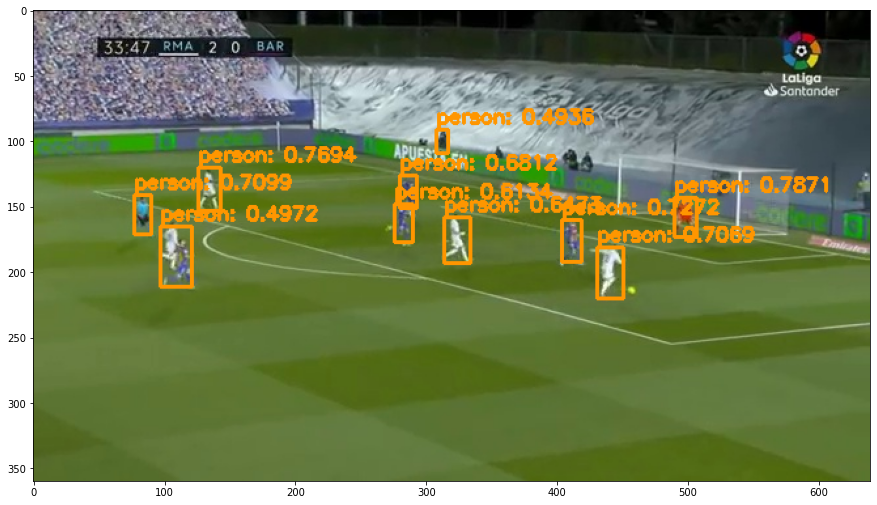

In [61]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

# cv2.imshow("frame", cv2_img_bb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("--- %.2f seconds ---" % (time.time() - start_time))

https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

The `stepSize` indicates how many pixels we are going to skip in both the (x, y) direction. 

Normally, we would not want to loop over each and every pixel of the image (i.e. `stepSize`=1) as this would be computationally prohibitive if we were applying an image classifier at each window.

Instead, the `stepSize` is determined on a **per-dataset** basis and is tuned to give optimal performance based on your dataset of images. 

In practice, it’s common to use a `stepSize` of 4 to 8 pixels. 

**Remember, the smaller your step size is, the more windows you’ll need to examine.**

In [53]:
from PIL import Image
import math

def sliding_window(img, step_size, window_size):
#     img = Image.open(input_file)
    
    img_width, img_height = img.size
    for y in range(0, img_height, step_size):
        for x in range(0, img_width, step_size):
            box = (x, y, x+window_size[0], y+window_size[1])
            
            if x+window_size[0] <= img_width  and y+window_size[1] <= img_height :
                yield (box, img.crop(box))
                
# *to change* 
# check if objects already detected before adding it to list
def keep_unique_objects_df(boxes_df, epsilon=10):
    ## Remove duplicate objects ##    
    distances = boxes_df.distance.to_list()

    for distance in distances:
        first = True

        for index, row in boxes_df.iterrows():
            if first and abs(row.distance-distance) < epsilon:
                first = False
                continue
            else:
                if abs(row.distance-distance) < epsilon:
                    boxes_df.drop(index, inplace=True)   
    return boxes_df


def split_image_and_predict(img, model, step_size=64, window_size=(256,256)):
    
    img = Image.fromarray(img[:,:,::-1])
    
    boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])
    
    for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
       
        # inference
        results = model(img, size=320)  # includes NMS
        boxes = results.pandas().xyxy[0]
 
        # project to starting image
        boxes.xmin = boxes.xmin+box[0]
        boxes.xmax = boxes.xmax+box[0]

        boxes.ymin = boxes.ymin+box[1]
        boxes.ymax = boxes.ymax+box[1]

        boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
        boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
        boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)

        boxes_df = boxes_df.append(boxes, ignore_index=True)

    boxes_df = keep_unique_objects_df(boxes_df)

    return boxes_df

--- 1.57 seconds ---


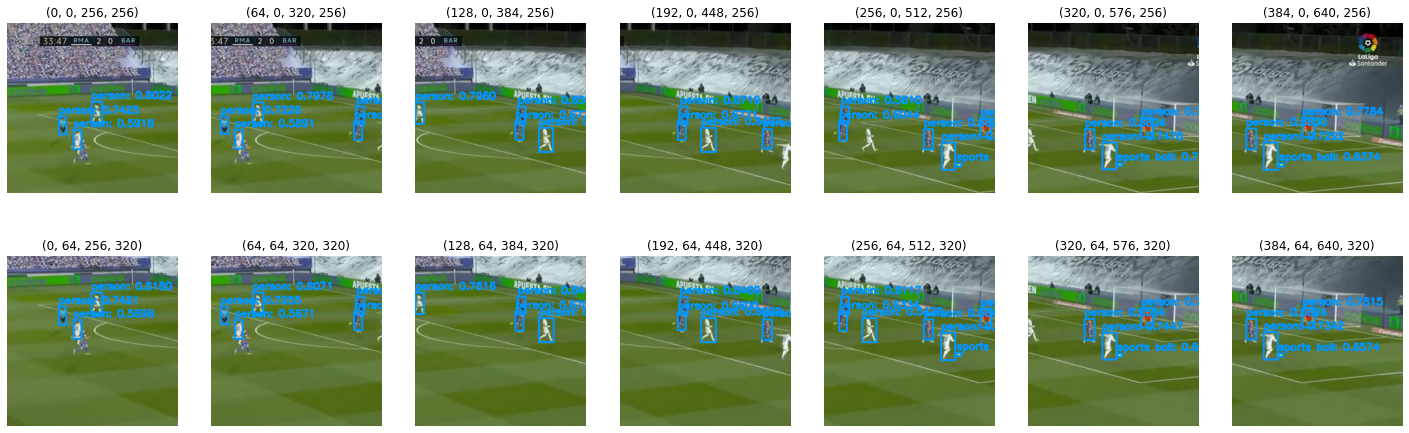

In [59]:
from PIL import Image
import math


fig = plt.figure(figsize=(25, 25))

img_path = './Images/video1/frame30.jpg'
img = Image.open(img_path)
img_width, img_height = img.size

step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
 
    # inference
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
  
    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)
    plt.title(box)
    plt.imshow(cv2_img_bb)
    plt.axis('off')
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
boxes_df = keep_unique_objects_df(boxes_df)

                
                
print("--- %.2f seconds ---" % (time.time() - start_time))

In [55]:
boxes_df

,xmin,ymin,xmax,ymax,confidence,class,name,centerx,centery,distance
0,80.189484,85.336990,253.830978,254.957489,0.876365,0,person,167.010231,170.147240,238.416653
1,118.223190,16.268011,254.616364,205.621048,0.351080,0,person,186.419777,110.944530,216.935525
2,81.858765,83.510178,288.407074,254.759247,0.821033,0,person,185.132919,169.134712,250.760341
3,181.572975,15.739734,319.724121,250.785248,0.618006,0,person,250.648548,133.262491,283.872482
5,320.483871,114.650146,384.000000,255.859055,0.676068,0,person,352.241936,185.254601,397.986995
9,322.372192,120.656334,447.753510,255.319824,0.797417,0,person,385.062851,187.988079,428.500778
10,256.377252,57.093769,340.365387,254.419113,0.850932,0,person,298.371320,155.756441,336.579134
11,322.818184,63.321266,510.650635,255.539673,0.750367,0,person,416.734409,159.430470,446.190142
13,384.868121,60.870796,526.512115,255.934082,0.839035,0,person,455.690118,158.402439,482.436334
18,320.516937,110.455456,383.527542,318.591888,0.775038,0,person,352.022240,214.523672,412.237872


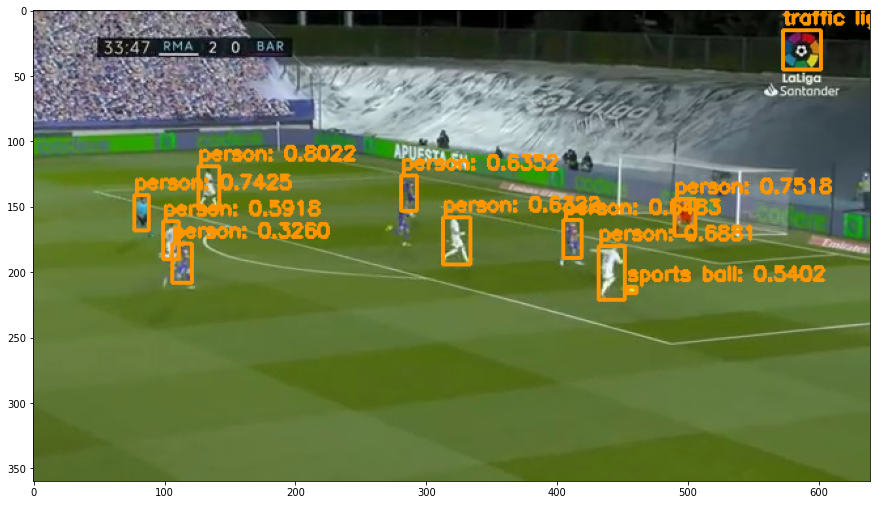

In [58]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

img = cv2.imread('./Images/video1/frame30.jpg', cv2.IMREAD_COLOR)

boxes =  split_image_and_predict(img, model)

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

In [57]:
boxes

,xmin,ymin,xmax,ymax,confidence,class,name,centerx,centery,distance
0,80.189484,85.336990,253.830978,254.957489,0.876365,0,person,167.010231,170.147240,238.416653
1,118.223190,16.268011,254.616364,205.621048,0.351080,0,person,186.419777,110.944530,216.935525
2,81.858765,83.510178,288.407074,254.759247,0.821033,0,person,185.132919,169.134712,250.760341
3,181.572975,15.739734,319.724121,250.785248,0.618006,0,person,250.648548,133.262491,283.872482
5,320.483871,114.650146,384.000000,255.859055,0.676068,0,person,352.241936,185.254601,397.986995
9,322.372192,120.656334,447.753510,255.319824,0.797417,0,person,385.062851,187.988079,428.500778
10,256.377252,57.093769,340.365387,254.419113,0.850932,0,person,298.371320,155.756441,336.579134
11,322.818184,63.321266,510.650635,255.539673,0.750367,0,person,416.734409,159.430470,446.190142
13,384.868121,60.870796,526.512115,255.934082,0.839035,0,person,455.690118,158.402439,482.436334
18,320.516937,110.455456,383.527542,318.591888,0.775038,0,person,352.022240,214.523672,412.237872
